In [322]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error

In [323]:
#loading the dataset
df_original=pd.read_csv("/content/Medical_insurance.csv")
df=df_original.copy()

In [324]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [326]:
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [327]:
df.shape

(2772, 7)

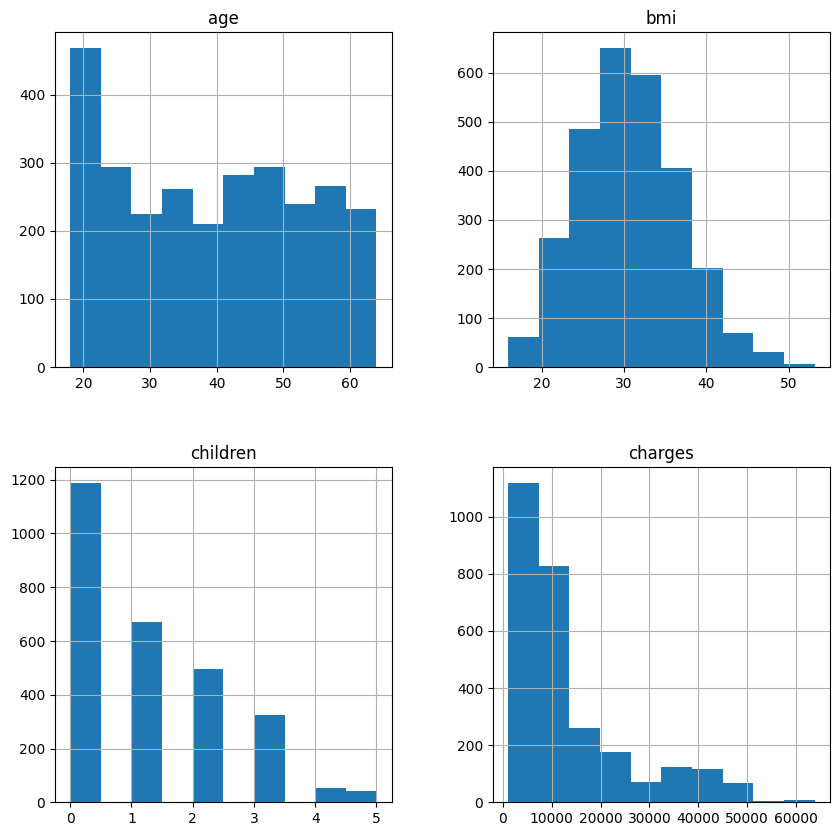

In [328]:
#EDA
df.hist(figsize=(10,10))
plt.show()

<Axes: xlabel='age', ylabel='charges'>

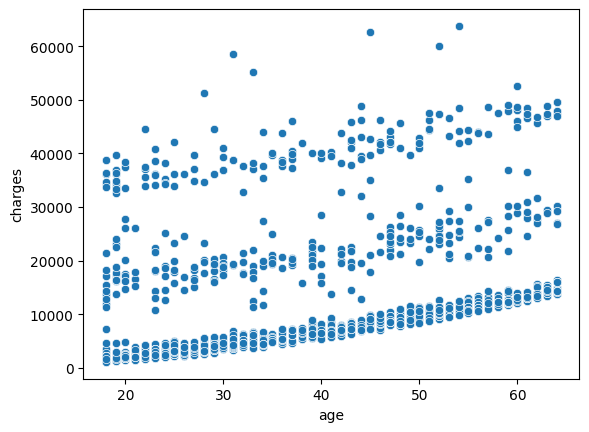

In [329]:
sns.scatterplot(x=df["age"],y=df["charges"])

<Axes: xlabel='bmi', ylabel='charges'>

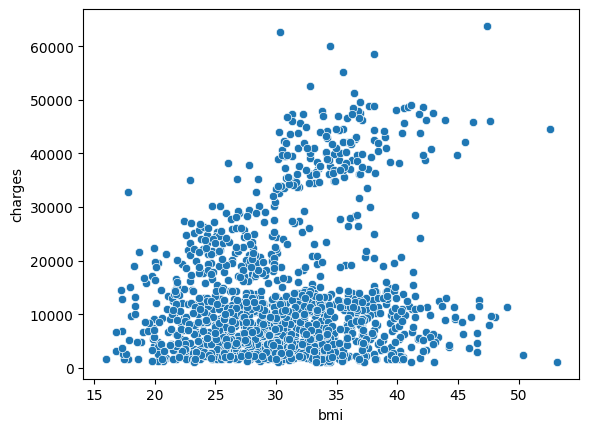

In [330]:
sns.scatterplot(x=df["bmi"],y=df["charges"])

<Axes: xlabel='sex', ylabel='charges'>

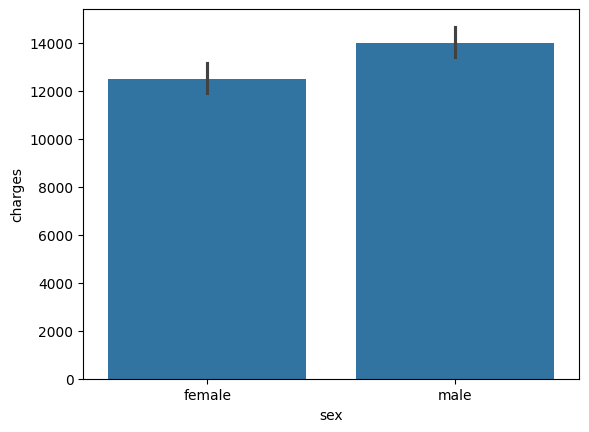

In [331]:
sns.barplot(x=df["sex"],y=df["charges"])

<Axes: xlabel='smoker', ylabel='charges'>

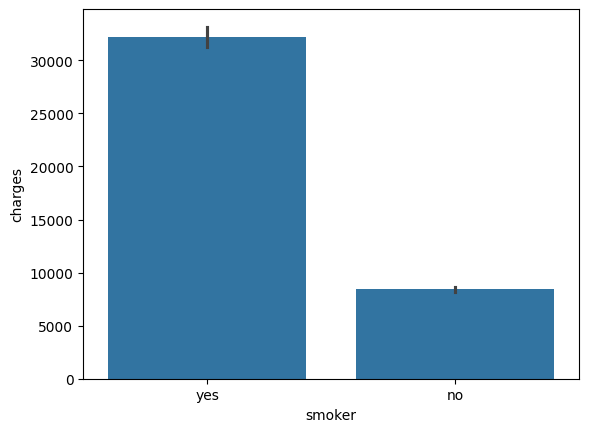

In [332]:
sns.barplot(x=df["smoker"],y=df["charges"])

<Axes: xlabel='region', ylabel='charges'>

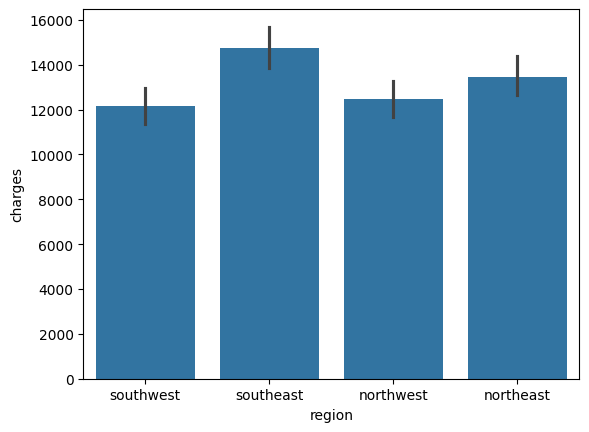

In [333]:
sns.barplot(x=df["region"],y=df["charges"])

In [334]:
#changing the categories of sex and smoker to numerical
df["sex"]=df["sex"].map({"male":0,"female":1})
df["smoker"]=df["smoker"].map({"yes":1,"no":0})

In [335]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520


In [336]:
X=df.drop("charges",axis=1)
y=df["charges"]

In [337]:
num_cols=["age","bmi"]
cat_cols=["sex","smoker","region"]

In [338]:
#outlier detection
Q1=df[num_cols].quantile(0.25)
Q3=df[num_cols].quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
print(df[num_cols][(df[num_cols]<lower_bound)|(df[num_cols]>upper_bound)].count())

age     0
bmi    14
dtype: int64


In [339]:
Q1=df["bmi"].quantile(0.25)
Q3=df["bmi"].quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
df["bmi"]=np.where(df["bmi"]<lower_bound,df["bmi"].median(),df["bmi"])
df["bmi"]=np.where(df["bmi"]>upper_bound,df["bmi"].median(),df["bmi"])

In [340]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [341]:
df["region"].value_counts()

,count
region,
southeast,766
southwest,684
northwest,664
northeast,658


In [342]:
preprocessor = ColumnTransformer([
    ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_cols),
    ("scaler", StandardScaler(), num_cols)
])

In [343]:
def pipeline(model):
  return Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

In [344]:
models={
    "LinearRegression":LinearRegression(),
    "RandomForestRegressor":RandomForestRegressor(),
    "XGBRegressor":XGBRegressor()
}

In [345]:
result=[]
for name,model in models.items():
  pipe=pipeline(model)
  pipe.fit(X_train,y_train)
  y_pred=pipe.predict(X_test)
  r2=r2_score(y_test,y_pred)
  mae=mean_absolute_error(y_test,y_pred)
  result.append((name,r2,mae))


In [346]:
#display result
result_df=pd.DataFrame(result,columns=["Model","R2","MAE"])
print(result_df)

                   Model        R2          MAE
0       LinearRegression  0.742025  4272.109424
1  RandomForestRegressor  0.930485  1597.294995
2           XGBRegressor  0.933666  1464.134633


In [347]:
rf_model=models["XGBRegressor"]
new_data=pd.DataFrame([[19,"female",27.9,0,"yes","southwest"]],columns=["age","sex","bmi","children","smoker","region"])
new_data=preprocessor.transform(new_data)
predicted_charges=rf_model.predict(new_data)
print(predicted_charges)

[16752.53]
